<H1><b>Average Monthly Income & Venues Data Analysis of Thailand

<H2>A1 Background and Problem

   Thailand the country at the center of the Southeast Asian Indochinese with population about 68 million people, composed of 77 provinces, was the most visited country in Southeast Asia in 2013, according to the World Tourism Organization.
    
   As a resident of Thailand, I would like to study the average monthly income in each provinces of Thailand therefore both government and investor might use the information for making long-term strategic planing. 
   
   In order to forecast the average monthly income, we could use the venues data because in each provinces if people has higher monthly income, the consumable ability will be higher then the investment in each venues will be higher and vice versa.

<H2>A2 description of the data

1. Name of each provinces from **Wikipedia**
  * Cleaning and Making initial dataframe 
2. The average monthly income from **Thailand government open data**.
  * Matching with the dataframe
3. Latitude and Longitude from **Google**.
  * Matching with the dataframe
4. Common venues from **Four Square** for each provinces of Thailand.
  * Ranking the most common venues in each provinces
  * Merging with the dataframe
5. Thailand Geojson file from **Github/apisit** for choropleth map.
  * Solving the unmatched province name.

<H2>B.Methodology

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import folium # map rendering library
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
!conda install -c conda-forge folium=0.5.0 --yes
import folium
print("Completed")

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::anaconda==5.3.1=py37_0
  - defaults/linux-64::astropy==3.0.4=py37h14c3975_0
  - defaults/linux-64::bkcharts==0.2=py37_0
  - defaults/linux-64::blaze==0.11.3=py37_0
  - defaults/linux-64::bokeh==0.13.0=py37_0
  - defaults/linux-64::bottleneck==1.2.1=py37h035aef0_1
  - defaults/linux-64::dask==0.19.1=py37_0
  - defaults/linux-64::datashape==0.5.4=py37_1
  - defaults/linux-64::mkl-service==1.1.2=py37h90e4bf4_5
  - defaults/linux-64::numba==0.39.0=py37h04863e7_0
  - defaults/linux-64::numexpr==2.6.8=py37hd89afb7_0
  - defaults/linux-64::odo==0.5.1=py37_0
  - defaults/linux-64::pytables==3.4.4=py37ha205bf6_0
  - defaults/linux-64::pytest-arraydiff==0.2=py37h39e3cac_0
  - defaults/linux-64::pytest-astropy==0.4.0=py37_0
  - defaults/linux-64::pytest-doctestplus==0.1.3=py37_0
  - defaults/linux-64::pywavelets==1.0.0=py37h

<H3>1. Load perpared data

In [2]:
df = pd.read_csv('LAT LONG THAI3.csv')
df.head()

,CAP_Name,Name,Population,Area,LAT,LONG,AVG M Income
0,AMNAT CHAROEN,Amnat Charoen,378107,3161,15.86570,104.625800,21172.9
1,ANG THONG,Ang Thong,281187,968,14.58960,100.455100,23350.6
2,BANGKOK,Bangkok,5682415,1565,13.75630,100.501800,45571.7
3,BUENG KAN,Bueng Kan,423032,4306,18.36303,103.651940,23766.6
4,BURIRAM,Buriram,1591905,10322,14.99300,103.102921,18479.6


<H3> 2.Get Venue data from **Four Square**

In [3]:
CLIENT_ID = 'RGZWN4PKE0NC2ICENJVDN2CF1J3L235A3JAFJRY4M2VAOCGA' # your Foursquare ID
CLIENT_SECRET = 'SCURMLNOHRWYNZM1W0BOTWYRUMZUBA3WK4XA5YMRAL5WLYLT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 #Limit per provinces

def getNearbyVenues(names, latitudes, longitudes, radius=2500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("Completed")
    return(nearby_venues)

In [4]:
Thai_venues = getNearbyVenues(names=df['Name'],
                                   latitudes=df['LAT'],
                                   longitudes=df['LONG']
                                  )

Completed


<H3> 3.Check Number of venues in each provinces

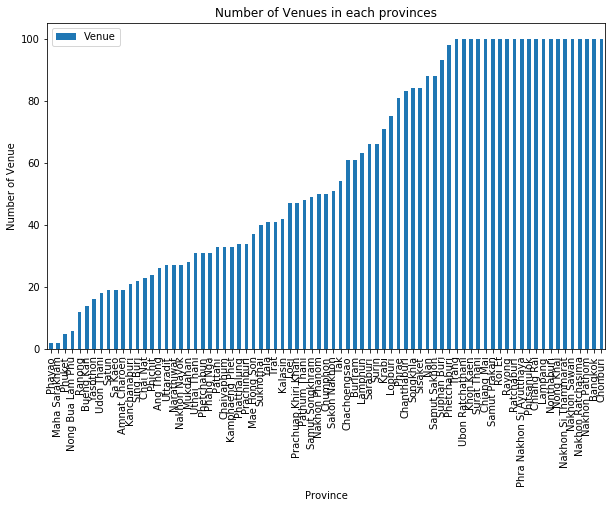

In [5]:
Thai_venues.groupby('Neighborhood').count()[['Venue']].sort_values('Venue').plot(kind='bar', figsize=(10, 6))

plt.xlabel('Province') # add to x-label to the plot
plt.ylabel('Number of Venue') # add y-label to the plot
plt.title('Number of Venues in each provinces') # add title to the plot

plt.show()

<H3>4.Summary data from Four square

In [6]:
Thai_onehot = pd.get_dummies(Thai_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Thai_onehot['Neighborhood'] = Thai_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Thai_onehot.columns[-1]] + list(Thai_onehot.columns[:-1])
Thai_onehot = Thai_onehot[fixed_columns]


Thai_grouped = Thai_onehot.groupby('Neighborhood').sum().reset_index()
Thai_grouped.head()

,Neighborhood,Zoo,Airport,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,University,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wings Joint,Yoga Studio
0,Amnat Charoen,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Ang Thong,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,Bangkok,0,0,0,0,0,1,0,5,0,...,0,3,0,1,0,0,0,0,0,0
3,Bueng Kan,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
4,Buriram,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


<H3>5. Grouping data from **Four square**

In [7]:
df_temp = Thai_grouped.copy()

set_Restaurant=['Restaurant','American Restaurant','Asian Restaurant','Vegetarian / Vegan Restaurant',
                'Thai Restaurant','Vietnamese Restaurant','BBQ Joint',
               'Chinese Restaurant','Comfort Food Restaurant','Cupcake Shop','Dim Sum Restaurant', 'Diner',
                'Donut Shop', 'Dumpling Restaurant','Dessert Shop', 'Eastern European Restaurant',
                'Fast Food Restaurant', 'Food', 'Food & Drink Shop', 'Food Court',
               'Food Stand', 'Food Truck','Fried Chicken Joint','Frozen Yogurt Shop','German Restaurant',
               'Halal Restaurant','Hotpot Restaurant', 'Ice Cream Shop','Indian Restaurant',
               'Italian Restaurant','Japanese Restaurant','Korean Restaurant','Malay Restaurant', 
                'Mexican Restaurant','Mediterranean Restaurant','Ramen Restaurant','Noodle House',
               'Pizza Place','Salad Place','Satay Restaurant','Sushi Restaurant',
               'Seafood Restaurant', 'Shabu-Shabu Restaurant','Som Tum Restaurant',
                'Street Food Gathering','Smoothie Shop','Bubble Tea Shop',
               'Bed & Breakfast', 'Bistro', 'Breakfast Spot','Creperie','Buffet',  
                'Burger Joint', 'Steakhouse']
set_Bar=['Whisky Bar', 'Wine Bar','Bar','Beach Bar','Beer Bar', 'Beer Garden','Brewery','Cocktail Bar',
        'Cocktail Bar','Dive Bar','Hookah Bar','Irish Pub','Juice Bar', 'Karaoke Bar','Hotel Bar',
        'Nightclub','Pub', 'Sports Bar']
set_Gym=['Athletics & Sports','Bakery','Basketball Court','Gym / Fitness Center','Tennis Stadium',
        'Badminton Court', 'Golf Course', 'Sports Club', 'Stadium', 'Soccer Stadium',
         'Yoga Studio']
set_Cafe=['Cafeteria', 'Café','Coffee Shop']
set_Landscape=['Beach','Bridge','Cave','Intersection','Lake','River', 'Mountain','Waterfront']
set_Auto=['Auto Dealership','Auto Garage', 'Auto Workshop']
set_Market=['Butcher',  'Farmers Market', 'Fish Market', 'Flea Market', 'Floating Market',
            'Fruit & Vegetable Store', 'Night Market','Market']
set_Shop=['Cosmetics Shop','Gift Shop','Gourmet Shop','Miscellaneous Shop', 
          'Mobile Phone Shop','Motorcycle Shop' , 'Flower Shop', 'Sporting Goods Shop']            
set_Accommodation=[ 'Boarding House', 'Hotel', 'Hotel Pool', 'Motel','Resort', 
                   'Residential Building (Apartment / Condo)']


df_temp.drop(set_Restaurant,1,inplace=True)
df_temp.drop(set_Bar,1,inplace=True)
df_temp.drop(set_Gym,1,inplace=True)
df_temp.drop(set_Cafe,1,inplace=True)
df_temp.drop(set_Landscape,1,inplace=True)
df_temp.drop(set_Auto,1,inplace=True)
df_temp.drop(set_Market,1,inplace=True)
df_temp.drop(set_Shop,1,inplace=True)
df_temp.drop(set_Accommodation,1,inplace=True)


df_temp['Restaurant']=Thai_grouped[set_Restaurant].sum(1)
df_temp['Bar']=Thai_grouped[set_Bar].sum(1)
df_temp['Gym']=Thai_grouped[set_Gym].sum(1)
df_temp['Cafe']=Thai_grouped[set_Cafe].sum(1)
df_temp['Landscape']=Thai_grouped[set_Landscape].sum(1)
df_temp['Auto']=Thai_grouped[set_Auto].sum(1)
df_temp['Market']=Thai_grouped[set_Market].sum(1)
df_temp['Shop']=Thai_grouped[set_Shop].sum(1)
df_temp['Accommodation']=Thai_grouped[set_Accommodation].sum(1)

Thai_grouped=df_temp
Thai_grouped.head()

,Neighborhood,Zoo,Airport,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Beer Store,Big Box Store,Boat or Ferry,...,Warehouse Store,Wings Joint,Restaurant,Bar,Cafe,Landscape,Auto,Market,Shop,Accommodation
0,Amnat Charoen,0,0,0,0,0,0,0,0,0,...,0,0,9,2,2,0,0,0,1,1
1,Ang Thong,0,0,0,0,0,0,0,0,0,...,0,0,11,0,3,1,0,2,1,1
2,Bangkok,0,0,0,0,1,0,0,0,0,...,0,0,35,12,9,0,0,0,0,6
3,Bueng Kan,0,0,0,0,0,0,0,1,0,...,0,0,5,0,2,0,0,0,0,2
4,Buriram,0,0,0,0,0,0,0,0,0,...,0,0,24,3,8,0,0,3,1,10


<H3> 6.Ranking most common venues in each provinces

In [8]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

def get_explain(row):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    N1=row_categories_sorted[0]
    N2=row_categories_sorted[1]
    N3=row_categories_sorted[2]
    
    V1=row_categories_sorted.index.values[0]
    V2=row_categories_sorted.index.values[1]
    V3=row_categories_sorted.index.values[2]
    
    return (str(N1)+V1+" "+str(N2)+V2+" "+str(N3)+V3+" ")
    
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Thai_grouped['Neighborhood']
neighborhoods_explain = Thai_grouped[['Neighborhood']].copy()
neighborhoods_explain['explain']=''
for ind in np.arange(Thai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Thai_grouped.iloc[ind, :], num_top_venues)
for ind in np.arange(Thai_grouped.shape[0]):
    neighborhoods_explain['explain'][ind]=get_explain(Thai_grouped.iloc[ind, :])

#neighborhoods_explain.head()
neighborhoods_venues_sorted = neighborhoods_venues_sorted.join(neighborhoods_explain.set_index('Neighborhood'), on='Neighborhood')
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,explain
0,Amnat Charoen,Restaurant,Cafe,Bar,Accommodation,Shop,Gym,Pharmacy,Department Store,Art Gallery,Gym Pool,9Restaurant 2Cafe 2Bar
1,Ang Thong,Restaurant,Cafe,Convenience Store,Market,Accommodation,Buddhist Temple,Shop,Home Service,Gym,Shopping Mall,11Restaurant 3Cafe 3Convenience Store
2,Bangkok,Restaurant,Bar,Cafe,Accommodation,Massage Studio,History Museum,Palace,Park,Spa,Gym,35Restaurant 12Bar 9Cafe
3,Bueng Kan,Restaurant,Accommodation,Cafe,Department Store,Convenience Store,Park,Big Box Store,Scenic Lookout,History Museum,Historic Site,5Restaurant 2Accommodation 2Cafe
4,Buriram,Restaurant,Accommodation,Cafe,Market,Bar,Convenience Store,Gym,Monument / Landmark,Department Store,Shopping Mall,24Restaurant 10Accommodation 8Cafe


<H3> 6. Find best k for K-Mean clustering

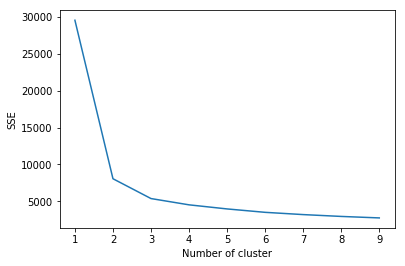

In [9]:
Thai_grouped_clustering = Thai_grouped.drop('Neighborhood', 1)
# run k-means clustering
sse = {}
for k in range(1, 10):
    #,max_iter=1000
    kmeans = KMeans(n_clusters=k,max_iter=1000,random_state=0).fit(Thai_grouped_clustering)
    #data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

<H3> 7. Chose K=3 then merging with initial dataframe

In [10]:
kclusters=3
kmeans = KMeans(n_clusters=kclusters).fit(Thai_grouped_clustering)

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Thai_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Thai_merged = Thai_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Name')

Thai_merged =Thai_merged.dropna()
#A=Thai_merged.where(Thai_merged['Cluster Labels']!=Thai_merged['Cluster Labels'].unique()[4],10)
#Thai_merged.where(A['Cluster Labels']==10).dropna()


<H3> 8.0 Define Cluster : But the 1st Most Common Venue is Restaurant so we check the 2nd

In [35]:
df_temp=Thai_merged.iloc[:,8:9].describe()
df_temp

,1st Most Common Venue
count,77
unique,3
top,Restaurant
freq,75


<H3>8.1 Define Cluster[0] name : Medium Cafe

In [36]:
df_temp=Thai_merged.iloc[:,7:18]
A1= df_temp.where(df_temp['Cluster Labels']==0).dropna().iloc[:,2:3].values.tolist()
A=pd.DataFrame(np.unique(A1, return_counts=True)).transpose().sort_values(1,ascending=False)
A[1]=A[1]/len(df_temp.where(df_temp['Cluster Labels']==0).dropna())
C0=A.iloc[0:10]
C0

,0,1
2,Cafe,0.631579
0,Accommodation,0.157895
3,Convenience Store,0.105263
1,Bar,0.0526316
4,Market,0.0526316


<H3>8.2 Define Cluster[1] name : Medium Cafe and Accomodation

In [37]:
df_temp=Thai_merged.iloc[:,7:18]
A1= df_temp.where(df_temp['Cluster Labels']==1).dropna().iloc[:,2:3].values.tolist()
A=pd.DataFrame(np.unique(A1, return_counts=True)).transpose().sort_values(1,ascending=False)
A[1]=A[1]/len(df_temp.where(df_temp['Cluster Labels']==1).dropna())
C1=A.iloc[0:10]
C1

,0,1
5,Cafe,0.441176
0,Accommodation,0.352941
7,Market,0.0588235
1,Airport,0.0294118
2,Arcade,0.0294118
3,Boat or Ferry,0.0294118
4,Business Service,0.0294118
6,Convenience Store,0.0294118


<H3>8.3 Define Cluster[2] name : High Cafe

In [38]:
df_temp=Thai_merged.iloc[:,7:18]
A1= df_temp.where(df_temp['Cluster Labels']==2).dropna().iloc[:,2:3].values.tolist()
A=pd.DataFrame(np.unique(A1, return_counts=True)).transpose().sort_values(1,ascending=False)
A[1]=A[1]/len(df_temp.where(df_temp['Cluster Labels']==2).dropna())
C2=A.iloc[0:10]
C2


,0,1
0,Cafe,0.958333
1,Convenience Store,0.0416667


<H3> C.Results

In [30]:
Thailand_geo = r'Thailand2.json'
latitude=13.7563
longitude = 100.5018
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=5, tiles='Mapbox Bright')

# set color map for Average Monthly Income
map_clusters.choropleth(
    geo_data=Thailand_geo,
    data=df,
    columns=['Name', 'AVG M Income'],
    key_on='feature.properties.name',
    fill_color='Blues', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Monthly Income'
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,explain in zip(Thai_merged['LAT'], Thai_merged['LONG'], Thai_merged['Name'], Thai_merged['Cluster Labels'], Thai_merged['explain']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    #)str(explain)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<H3> D. Discussion

First after we get venues data from Four square we can see that some provinces has very low venues and 
some provinces has reach limit 100 venues because there are high and low density of population in Thailand.

Then we do the ranking and found that the restaurant is the most common venues in each country, we can also see
it from the grouping there are many kind of restaurant in Thailand.

Then we try to find the best K in K-Mean clustering by elbow method then we chose k=3 to do the clustering

After we did clustering the results we can see that the restaurants is the highest common venues in every provinces,
then the cafe and accomodation, so we can see that we can define the name by 
- Cluster[0] : Medium Cafe
- Cluster[1] : Medium Cafe and Accomodation
- Cluster[2] : High Cafe

Then we map each group of provinces based on each cluster, We can see that at the Bangkok capital provinces of Thailand
There are many "Cluster[2] : High Cafe" in that area and also Bangkok has the most average monthly income in Thailand.

<H3> E.Conclusion

As a result, the higher average monthly income province tend to has many restaurant and cafe, we may observe the growth or expansion of the province
by observe new restaurant or cafe in each sub district then predict the expansion of its.


Not only for investors but also city managers can manage the city more regularly by using similar data analysis types or platforms.